In [13]:
import math
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import time
import routing
from routing import VRPInstance, VRPModel
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [14]:
numb_customers = 20
data_df = pd.read_csv('data.dat', sep='\s+')
data_dict_rows = data_df.to_dict(orient='records')
locations = {row['CUST_NO'] : row for row in data_dict_rows if row['CUST_NO'] <= numb_customers}
depot = 1
cost_per_mile = 1
avg_speed = 1 # miles per hour
n = len(locations)

In [15]:
# table_df = data_df.head(10)
# latex_table = table_df.to_latex(index=False)
# #print(latex_table)

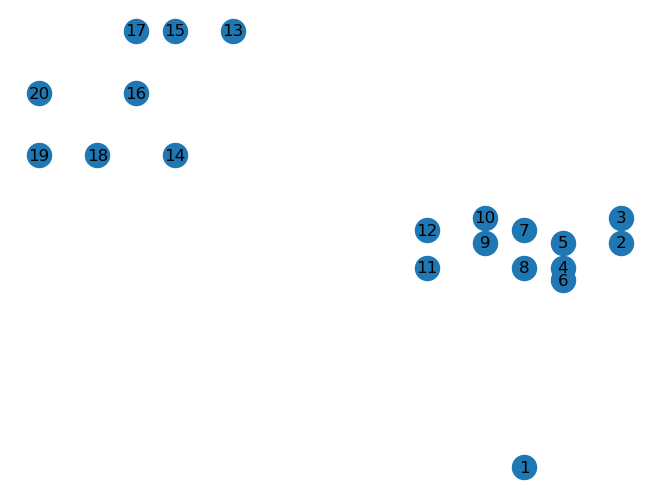

In [16]:
routing.show_tours([], locations, to_tikz=True, tikz_file_name='customers.tex')

Create dictionaries to hold problem data.

In [17]:
nodes = list(locations.keys())
edges = [(i,j) for i in nodes for j in nodes if i != j]
dist = {}
edge_costs = {}
travel_time = {}
for i in nodes:
    for j in nodes:
        x = routing.get_coordinate(locations, i)
        y = routing.get_coordinate(locations, j)
        dist[(i, j)] = routing.euclidean_distance(x, y)
        edge_costs[(i, j)] = routing.get_cost(x, y, cost_per_mile)
        travel_time[(i, j)] = routing.get_time(x, y, avg_speed)

# TSP

In [18]:
m = routing.create_tsp_model(depot, nodes, edge_costs)
routing.solve_model(m)

Optimal objective value: 116
Optimization time: 0.954 seconds


In [19]:
edges_used_gurobi = [(i, j) for i, j in edges if m._x[i, j].x > 0.5]
tour = routing.get_tour_from_edges_used(edges_used_gurobi)
print("complete tour", tour)
print("cost", routing.get_cost_of_tour(tour, edge_costs))
for i in tour[:-1]:
    print("Node", i, "visited at time", m._u[i].x)

complete tour [1, 11, 12, 14, 18, 19, 20, 16, 17, 15, 13, 10, 9, 7, 5, 3, 2, 4, 6, 8, 1]
cost 116
Node 1 visited at time 0.0
Node 11 visited at time 0.0
Node 12 visited at time 1.0
Node 14 visited at time 2.0
Node 18 visited at time 3.0
Node 19 visited at time 4.0
Node 20 visited at time 5.0
Node 16 visited at time 6.0
Node 17 visited at time 7.0
Node 15 visited at time 8.0
Node 13 visited at time 9.0
Node 10 visited at time 10.0
Node 9 visited at time 11.0
Node 7 visited at time 12.0
Node 5 visited at time 13.0
Node 3 visited at time 14.0
Node 2 visited at time 15.0
Node 4 visited at time 16.0
Node 6 visited at time 17.0
Node 8 visited at time 18.0


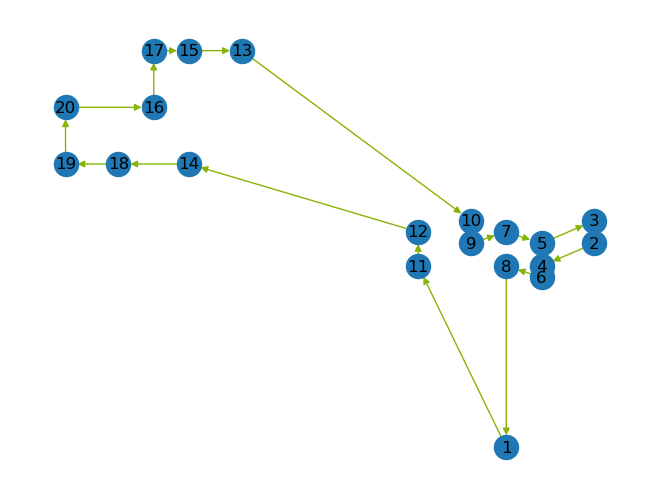

In [20]:
routing.show_tours([edges_used_gurobi], locations, to_tikz = True, tikz_file_name = "tsp.tex")

# TSP: Relaxation

In [21]:
m = routing.create_tsp_model(depot, nodes, edge_costs, relaxed=True)
routing.solve_model(m)
edges_used_adjacency_list= {i : {j : m._x[i, j].x for j in nodes} for i in nodes}
for i in edges_used_adjacency_list:
    for j in edges_used_adjacency_list[i]:
        if edges_used_adjacency_list[i][j] > 0.01:
            print((i,j), edges_used_adjacency_list[i][j])

Optimal objective value: 85
Optimization time: 0.002 seconds
(1, 8) 0.95
(1, 11) 0.050000000000000044
(2, 3) 0.95
(2, 5) 0.04999999999999993
(3, 2) 0.95
(3, 5) 0.04999999999999993
(4, 6) 1.0
(5, 2) 0.04999999999999993
(5, 3) 0.04999999999999993
(5, 7) 0.9000000000000001
(6, 1) 0.04999999999999999
(6, 4) 0.9
(6, 8) 0.04999999999999999
(7, 5) 0.9000000000000002
(7, 10) 0.09999999999999976
(8, 1) 0.9
(8, 4) 0.09999999999999998
(9, 7) 0.04999999999999993
(9, 10) 0.9000000000000002
(9, 12) 0.04999999999999982
(10, 7) 0.04999999999999993
(10, 9) 0.95
(11, 1) 0.04999999999999982
(11, 12) 0.9500000000000002
(12, 9) 0.050000000000000155
(12, 11) 0.9499999999999998
(13, 15) 0.04999999999999993
(13, 17) 0.9500000000000001
(14, 16) 0.9500000000000001
(14, 18) 0.04999999999999993
(15, 13) 0.95
(15, 17) 0.04999999999999993
(16, 14) 0.04999999999999993
(16, 20) 0.9500000000000001
(17, 13) 0.04999999999999993
(17, 15) 0.9500000000000001
(18, 14) 0.9500000000000001
(18, 19) 0.04999999999999993
(19, 18)

In [22]:
rounded_tour = routing.round_tsp_solution(edges_used_adjacency_list, n)
print("rounded_tour", rounded_tour)
complete_rounded = routing.complete_tour(rounded_tour)
print("cost", routing.get_cost_of_tour(complete_rounded, 
                                       edge_costs))

1 {8: 0.95, 11: 0.050000000000000044}
8 {4: 0.09999999999999998}
4 {6: 1.0}
6 {}
2 {3: 0.95, 5: 0.04999999999999993}
3 {5: 0.04999999999999993}
5 {7: 0.9000000000000001}
7 {10: 0.09999999999999976}
10 {9: 0.95}
9 {12: 0.04999999999999982}
12 {11: 0.9499999999999998}
11 {}
13 {15: 0.04999999999999993, 17: 0.9500000000000001}
17 {15: 0.9500000000000001}
15 {}
14 {16: 0.9500000000000001, 18: 0.04999999999999993}
16 {20: 0.9500000000000001}
20 {19: 0.9500000000000001}
19 {18: 0.95}
rounded_tour [1, 8, 4, 6, 2, 3, 5, 7, 10, 9, 12, 11, 13, 17, 15, 14, 16, 20, 19, 18]
cost 132


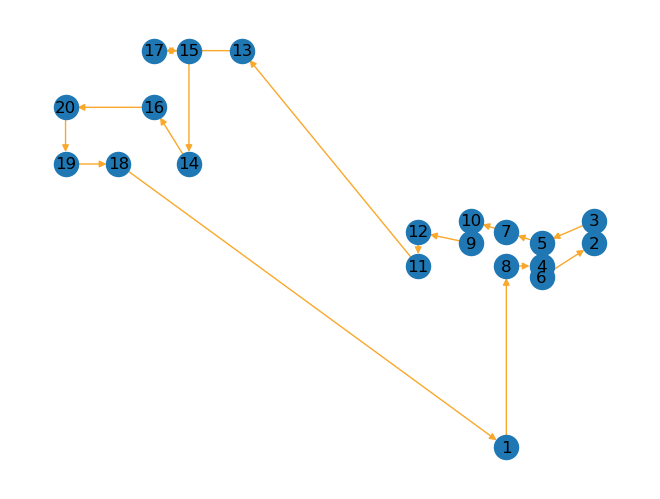

In [23]:
edges_used_rounded = routing.get_edges_used_from_tour(complete_rounded)
routing.show_tours([edges_used_rounded], locations, to_tikz = True, 
                   tikz_file_name = "tsp_rounded.tex")

# VRP with Time Windows (VRPTW)

In [24]:
num_vehicles  = 10
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = 100,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = 200,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model()
m.write("vrptw.lp")
routing.solve_model(m)

Optimal objective value: 825
Optimization time: 5.635 seconds


In [25]:
print("nodes", instance.nodes)
edges_used_list = []
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_gurobi_vrptw = [(i, j) for i, j in instance.edges if m._x[i, j, k].x > 0.5]
    edges_used_list.append(edges_used_gurobi_vrptw)
    print("edges used", edges_used_gurobi_vrptw)
    if len(edges_used_gurobi_vrptw) > 0:
        tour_vrptw = routing.get_tour_from_edges_used(edges_used_gurobi_vrptw)
        print("tour", tour_vrptw)
        for i in tour_vrptw[:-1]:
            print("Node", i, "visited at time", m._t[i,k].x)
        print("return time", m._return_time[k].x)

nodes [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
vehicle 0
edges used [(1, 6), (2, 76), (4, 8), (5, 2), (6, 4), (7, 5), (8, 9), (9, 11), (10, 7), (11, 12), (12, 10), (76, 1)]
tour [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 2, 76, 1]
Node 1 visited at time 0.0
Node 6 visited at time 15.13274595036637
Node 4 visited at time 106.13274595036637
Node 8 visited at time 198.1327459503664
Node 9 visited at time 290.96117307513487
Node 11 visited at time 384.5667243505595
Node 12 visited at time 498.7600351093556
Node 10 visited at time 591.9223127695718
Node 7 visited at time 684.1583807470729
Node 5 visited at time 776.394448724574
Node 2 visited at time 967

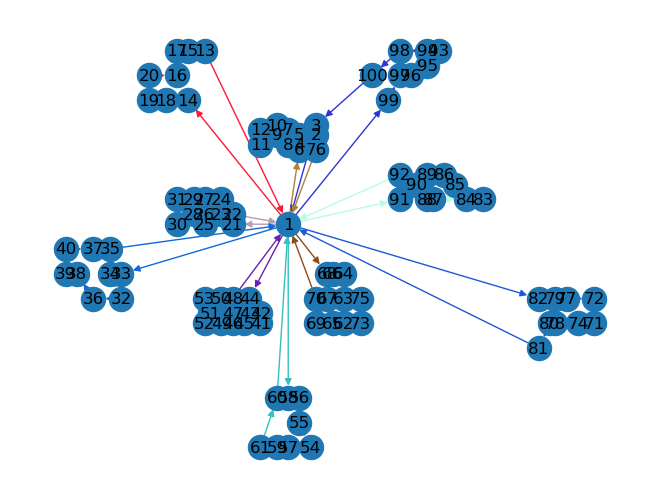

In [26]:
routing.show_tours(edges_used_list, instance.locations, to_tikz = True,
                   num_vehicles = num_vehicles,
                   tikz_file_name = "vrptw.tex")

# VRPTW: Relaxation

In [27]:
num_vehicles  = 2
instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = 5,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = 200,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(instance)
m = vrptw.get_gurobipy_model(relaxed = True)
routing.solve_model(m)

Optimal objective value: 72
Optimization time: 0.001 seconds


In [28]:
for k in instance.vehicles:
    print("vehicle", k)
    edges_used_adjacency_list= {i : {j : m._x[i, j,k].x for j in instance.nodes} for i in instance.nodes}
    for i in edges_used_adjacency_list:
        for j in edges_used_adjacency_list[i]:
            if edges_used_adjacency_list[i][j] > 0.01:
                print((i,j), edges_used_adjacency_list[i][j])

vehicle 0
(1, 5) 1.0
(2, 3) 0.999866
(3, 2) 0.9998659999999999
(5, 1) 1.0
vehicle 1
(1, 4) 1.0
(4, 1) 1.0


How can we round the VRP solution?